# Data Preprocessing & Analysis

### Importing Packages

In [1]:
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

### Importing the Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ay2324 sem1/cs3244/project/train.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
print(f"Initial dataframe has {len(df)} rows.")
null_rows = df[df.isnull().values.any(1)]
print(f"Dataframe has {len(null_rows)} null rows.")
df = df.dropna(how='any')
print(f"Dataframe has {len(df)} rows after removing null values.")

Initial dataframe has 404290 rows.
Dataframe has 3 null rows.
Dataframe has 404287 rows after removing null values.


In [6]:
num_samples = len(df)
num_samples

404287

### Splitting Dataset

In [7]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

In [8]:
# split into train/val, test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [9]:
X_train.shape[0]

291086

### WordCloud

(-0.5, 359.5, 269.5, -0.5)

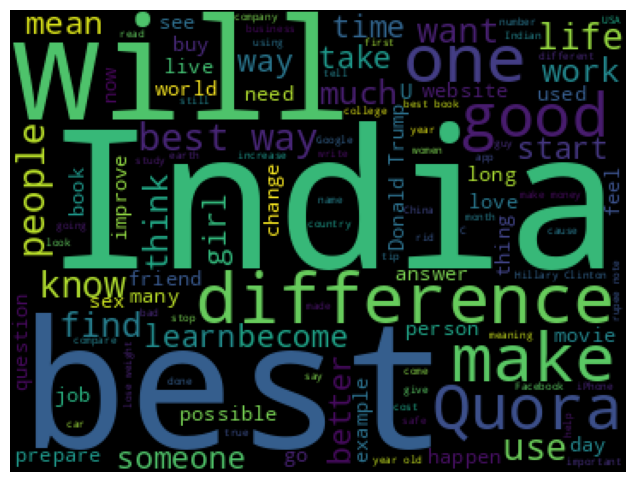

In [10]:
all_questions_concat = df['question1'].str.cat(sep=' ') + df['question2'].str.cat(sep=' ')

from wordcloud import WordCloud
cloud = WordCloud(width=360, height=270).generate(all_questions_concat)
plt.figure(figsize=(10, 6))
plt.imshow(cloud)
plt.axis('off')

### Checking for Class Imbalance

In [11]:
pos_class_count = len(df[df['is_duplicate'] == 1])
neg_class_count = num_samples - pos_class_count

pos_percentage = (pos_class_count / num_samples) * 100
neg_percentage = (neg_class_count / num_samples) * 100

print(f'Number of question pairs classified as duplicate: {pos_class_count}, ({pos_percentage:.2f}%)')
print(f'Number of question pairs classified as not duplicate: {neg_class_count}, ({neg_percentage:.2f}%)')

Number of question pairs classified as duplicate: 149263, (36.92%)
Number of question pairs classified as not duplicate: 255024, (63.08%)


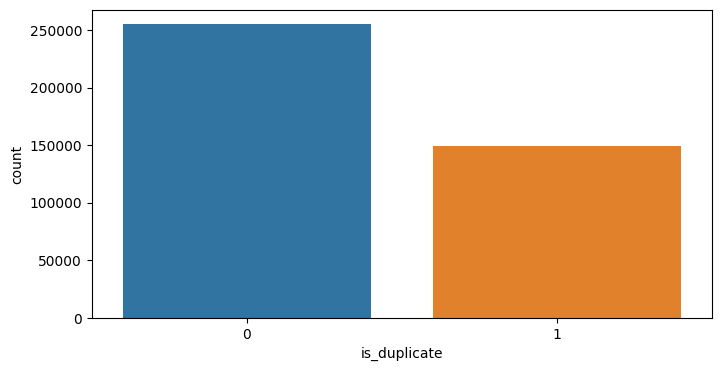

In [12]:
plt.figure(figsize=(8, 4))
sns.countplot(x='is_duplicate', data=df)
plt.xlabel('is_duplicate')
plt.ylabel('count')

plt.show()

### Checking for Duplicate Questions

In [13]:
question_ids = df['qid1'].to_list() + df['qid2'].to_list()
print(f"Total number of questions: {len(question_ids)}")

question_ids = pd.DataFrame(question_ids, columns=["qid"])
print(f"Unique questions: {len(question_ids['qid'].unique())}")

Total number of questions: 808574
Unique questions: 537929


In [14]:
question_counts = question_ids.value_counts()
question_counts

qid   
2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
223730      1
223729      1
223728      1
223727      1
537933      1
Length: 537929, dtype: int64

In [15]:
# look at an example of a duplicate question
dup = df[(df['qid1'] == 2559) | (df['qid2'] == 2559)]
dup.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
1283,1283,2558,2559,Why do I not lose weight when I throw up?,What are the best ways to lose weight?,0
2290,2290,4554,2559,Is it possible to reduce 17 lbs in one month?,What are the best ways to lose weight?,0


In [16]:
# questions that appear more than once
dup_questions = question_counts[question_counts > 1]
dup_questions

qid   
2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
312250      2
44805       2
7083        2
290851      2
9685        2
Length: 111778, dtype: int64

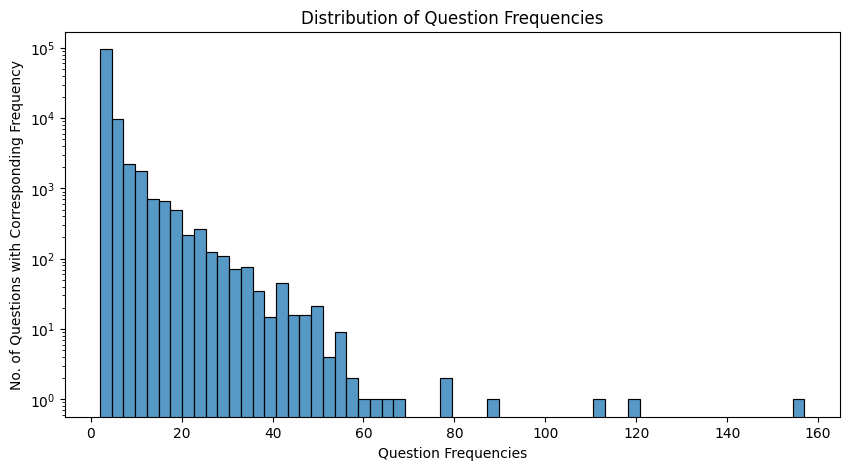

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(data=dup_questions, bins=60)
plt.xlabel('Question Frequencies')
plt.ylabel('No. of Questions with Corresponding Frequency')
plt.yscale('log')
plt.title('Distribution of Question Frequencies')
plt.show()

### Checking for Duplicate Rows

In [18]:
pair_counts = df[['qid1', 'qid2']].groupby(['qid1', 'qid2']).count().reset_index()
has_duplicate_pairs = not (len(pair_counts) == num_samples)
print(f'There are {"" if has_duplicate_pairs else "no "}duplicate pairs.')

There are no duplicate pairs.


### Data Preprocessing and Cleaning

In [19]:
!python -m nltk.downloader stopwords

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
import re
import string
from nltk.corpus import stopwords

def clean_text(text, remove_stopwords=False):
  text = text.lower() # lower case
  text = re.sub('\s+\n+', ' ', text)
  text = re.sub(f"[{re.escape(string.punctuation)}]", ' ', text) # remove punctuation
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # remove special chars

  if remove_stopwords:
    sw = set(stopwords.words("english"))
    text = ' '.join([word for word in text.split() if word not in sw])

  return text

demo_qn = "What's the meaning of life? #@"
clean_text(demo_qn), clean_text(demo_qn, remove_stopwords=True)

('what s the meaning of life    ', 'meaning life')

In [21]:
X_train['cleaned_question1'] = X_train['question1'].apply(clean_text)
X_train['cleaned_question2'] = X_train['question2'].apply(clean_text)
X_train.head(10)

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together
218521,218521,325147,325148,What are the most serious threats to the publi...,What are the most serious threats to public he...,what are the most serious threats to the publi...,what are the most serious threats to public he...
167795,167795,56163,260054,What are the problems facing the Philippines?,What problems have you faced on cruises?,what are the problems facing the philippines,what problems have you faced on cruises
19804,19804,37413,37414,Why can't the vas deferens be artificially con...,Renine is secreted in the vas afferens of the ...,why can t the vas deferens be artificially con...,renine is secreted in the vas afferens of the ...
109273,109273,63477,179365,How do I draw hair that looks realistic?,How do you draw realistic looking curly hair?,how do i draw hair that looks realistic,how do you draw realistic looking curly hair
85563,85563,14221,12852,How can one make money online?,How can I start to make money online?,how can one make money online,how can i start to make money online


### Word Count Analysis

I think this might help in determining the neural network architecture to use? The max question length is around 200 which might not work well if we are using RNNs, i.e. RNNs generally work well for shorter sequences.

In [22]:
# find word counts of questions
X_train['question1_word_count'] = X_train['cleaned_question1'].apply(lambda x: len(str(x).split()))
X_train['question2_word_count'] = X_train['cleaned_question2'].apply(lambda x: len(str(x).split()))
X_train.head(10)

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9
218521,218521,325147,325148,What are the most serious threats to the publi...,What are the most serious threats to public he...,what are the most serious threats to the publi...,what are the most serious threats to public he...,10,9
167795,167795,56163,260054,What are the problems facing the Philippines?,What problems have you faced on cruises?,what are the problems facing the philippines,what problems have you faced on cruises,7,7
19804,19804,37413,37414,Why can't the vas deferens be artificially con...,Renine is secreted in the vas afferens of the ...,why can t the vas deferens be artificially con...,renine is secreted in the vas afferens of the ...,16,28
109273,109273,63477,179365,How do I draw hair that looks realistic?,How do you draw realistic looking curly hair?,how do i draw hair that looks realistic,how do you draw realistic looking curly hair,8,8
85563,85563,14221,12852,How can one make money online?,How can I start to make money online?,how can one make money online,how can i start to make money online,6,8


Min word count for question 1: 0
Min word count for question 2: 0
Max word count for question 1: 128
Max word count for question 2: 248


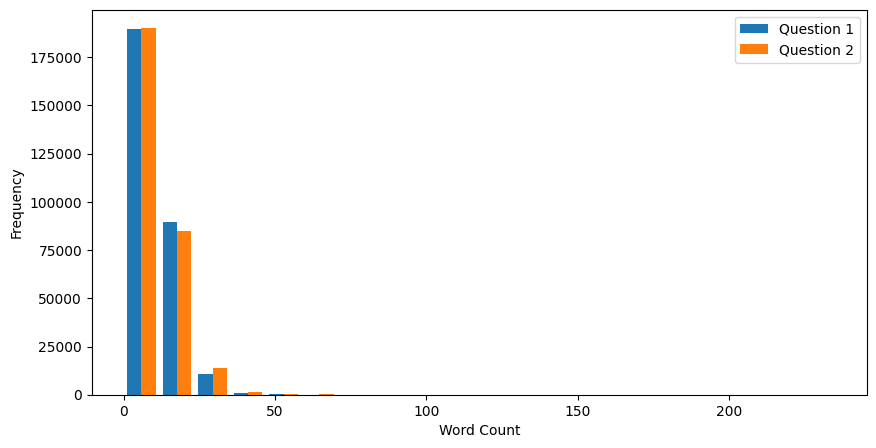

In [23]:
print(f"Min word count for question 1: {X_train['question1_word_count'].min()}")
print(f"Min word count for question 2: {X_train['question2_word_count'].min()}")

print(f"Max word count for question 1: {X_train['question1_word_count'].max()}")
print(f"Max word count for question 2: {X_train['question2_word_count'].max()}")

plt.figure(figsize=(10, 5))
plt.hist([X_train['question1_word_count'], X_train['question2_word_count']], bins=20, label=['Question 1', 'Question 2'], range=(0, 235))
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

In [24]:
X_train['question1_word_count'].describe()

count    291086.000000
mean         11.131013
std           5.577252
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         128.000000
Name: question1_word_count, dtype: float64

In [25]:
X_train['question2_word_count'].describe()

count    291086.000000
mean         11.368042
std           6.452340
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         248.000000
Name: question2_word_count, dtype: float64

In [26]:
X_train[(X_train['question1_word_count'] == 0) | (X_train['question2_word_count'] == 0)].head(2)

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count
226925,226925,335645,335646,Which in the best bike desert storm or Himalay...,????,which in the best bike desert storm or himalay...,,17,0
213220,213220,25026,64784,?,What is it like to work at Google?,,what is it like to work at google,0,8


In [27]:
word_count_bins = 20
hist, bin_edges = np.histogram(X_train['question1_word_count'], bins=word_count_bins)

bin_with_highest_freq = bin_edges[np.argmax(hist)]
bin_with_lowest_freq = bin_edges[np.argmin(hist)]
print(f"Word count with the highest frequency: {bin_with_highest_freq:1f}")
print(f"Word count with the lowest frequency: {bin_with_lowest_freq:1f}")

Word count with the highest frequency: 6.400000
Word count with the lowest frequency: 76.800000


### Word Frequency Analysis

Determine how many tokens we need. The data here is not cleaned yet so we might need much less tokens.

In [28]:
word_frequency = X_train['cleaned_question1'].str.cat(sep=' ').split() + X_train['cleaned_question2'].str.cat(sep=' ').split()
word_freq_dict = pd.Series(word_frequency).value_counts()

In [29]:
num_words = len(word_freq_dict)
print(f"Number of unique words/tokens: {num_words}")

Number of unique words/tokens: 74087


In [30]:
word_freq_dict.head(10)  # 10 most common words

the     271590
what    233110
is      194412
i       160854
how     159179
a       152809
to      148117
in      142239
do      115908
of      115106
dtype: int64

In [31]:
word_freq_dict.tail(10) # least common words

lovenox           1
undetected        1
clicker           1
1996use           1
specular          1
noncompetitive    1
spurts            1
reamma            1
arthrocentesis    1
pentameter        1
dtype: int64

### Matching Words in Both Questions

In [32]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [33]:
import nltk
from nltk.tokenize import word_tokenize

def calculate_common_word_proportion(question1, question2):
  tokens1 = list(set(word_tokenize(question1)))
  tokens2 = list(set(word_tokenize(question2)))

  # intersection of the token sets
  common_tokens = np.intersect1d(tokens1, tokens2)
  total_tokens = np.union1d(tokens1, tokens2)

  # proportion of common words (Jaccard similarity)
  proportion = (len(common_tokens) / len(total_tokens)) if not len(total_tokens) == 0 else 0

  return proportion

#### With Stopwords

In [34]:
X_train['common_word_proportion'] = X_train.apply(lambda row: calculate_common_word_proportion(row['cleaned_question1'], row['cleaned_question2']), axis=1)
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6,0.833333
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13,0.650000
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5,0.285714
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13,0.333333
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9,0.230769


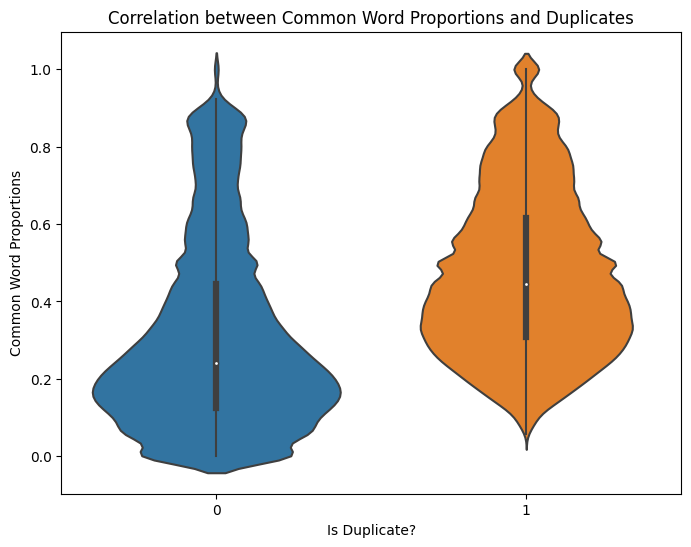

In [35]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='common_word_proportion', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Common Word Proportions')
plt.title('Correlation between Common Word Proportions and Duplicates')
plt.show()

There is not much of a correlation between the word proportions and whether the question pair is a duplicate or not. This could be due to the presence of stopwords.

In [36]:
correlation_coefficient = X_train['common_word_proportion'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.3282972524949151


#### Excluding Stopwords

In [37]:
X_train['no_stops_question1'] = X_train['question1'].apply(lambda x: clean_text(x, remove_stopwords=True))
X_train['no_stops_question2'] = X_train['question2'].apply(lambda x: clean_text(x, remove_stopwords=True))

In [38]:
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6,0.833333,colour water,colour water
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13,0.650000,would bedroom year 1980 look like would older ...,would older man bedroom look like year 1980
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5,0.285714,prosecco go,unopened champagne go bad
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13,0.333333,opt chemical engineering super interested chem...,study chemical engineering like good chemistry
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9,0.230769,eat eggs banana,dangerous eat bananas eggs together


In [39]:
X_train['common_word_proportion_no_stops'] = X_train.apply(lambda row: calculate_common_word_proportion(row['no_stops_question1'], row['no_stops_question2']), axis=1)
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6,0.833333,colour water,colour water,1.000000
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13,0.650000,would bedroom year 1980 look like would older ...,would older man bedroom look like year 1980,0.888889
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5,0.285714,prosecco go,unopened champagne go bad,0.200000
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13,0.333333,opt chemical engineering super interested chem...,study chemical engineering like good chemistry,0.333333
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9,0.230769,eat eggs banana,dangerous eat bananas eggs together,0.333333


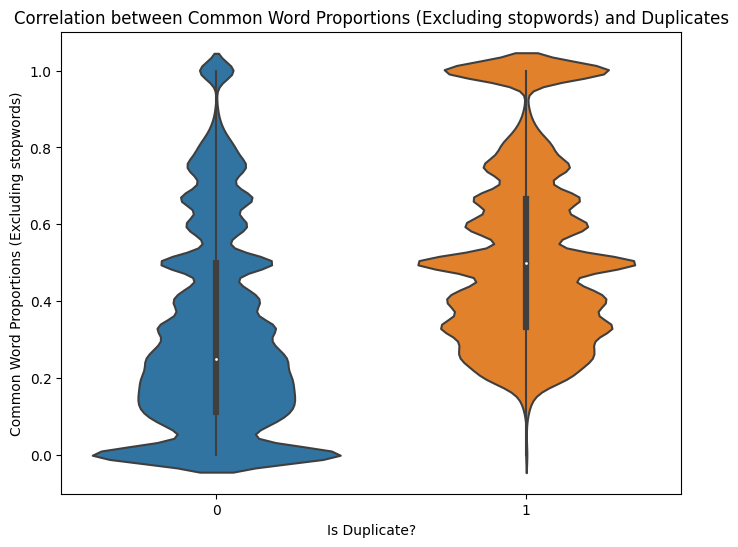

In [40]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='common_word_proportion_no_stops', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Common Word Proportions (Excluding stopwords)')
plt.title('Correlation between Common Word Proportions (Excluding stopwords) and Duplicates')
plt.show()

It can be observed from the plot above that there is a small correlation between the proportion of common words (excluding stopwords) and whether the question pair is a duplicate or not.

If the proportion of common words is low (close to zero), them there is a high probability that it is not a duplicate.

In this example, we treat all words equally. We can use TF-IDF to weigh each word so that if an uncommon word appears in both questions, it can be mean there is a higher chance of the questions being duplicates.

In [41]:
correlation_coefficient = X_train['common_word_proportion_no_stops'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.3904505808147075


#### TF-IDF Similarity

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load

vectorizer = TfidfVectorizer()

q1 = X_train['no_stops_question1']
q2 = X_train['no_stops_question2']

# fit questions
q1_concat_q2 = pd.concat([q1, q2])
tfidf_vectorizer = vectorizer.fit(q1_concat_q2)
tfidf_matrix = tfidf_vectorizer.transform(q1_concat_q2)

dump(tfidf_vectorizer, '/content/drive/MyDrive/ay2324 sem1/cs3244/project/tfidf_vectorizer.joblib')

['/content/drive/MyDrive/ay2324 sem1/cs3244/project/tfidf_vectorizer.joblib']

In [73]:
q1_concat_q2[:len(X_train)], q1_concat_q2[len(X_train):]

(107500                                         colour water
 300891    would bedroom year 1980 look like would older ...
 292925                                          prosecco go
 271797    opt chemical engineering super interested chem...
 230516                                      eat eggs banana
                                 ...                        
 1743      neoliberals big corporations feel entitled fre...
 220097            forever 21 popular clothing brand america
 219756                   donald trump wins presidency would
 240867    australia fm deny legitimacy tribunal australi...
 364364    difficult toefl average native speaker score w...
 Length: 291086, dtype: object,
 107500                                         colour water
 300891          would older man bedroom look like year 1980
 292925                            unopened champagne go bad
 271797       study chemical engineering like good chemistry
 230516                  dangerous eat bananas eggs t

In [74]:
tfidf_matrix.shape

(582172, 73910)

In [75]:
from sklearn.metrics.pairwise import cosine_similarity

def tfidf_word_share(doc1_idx, doc2_idx, tfidf_matrix):
  tfidf_doc1 = tfidf_matrix[doc1_idx]
  tfidf_doc2 = tfidf_matrix[doc2_idx]
  cosine_sim = cosine_similarity(tfidf_doc1, tfidf_doc2)
  similarity_score = cosine_sim[0][0]
  return similarity_score

In [76]:
X_train['tfidf_similarity'] = [tfidf_word_share(i, i + len(X_train), tfidf_matrix) for i in range(len(X_train))]

In [77]:
X_train.head(10)

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,embeddings_similarity
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6,0.833333,colour water,colour water,1.000000,1.000000,4,1,0.999637
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13,0.650000,would bedroom year 1980 look like would older ...,would older man bedroom look like year 1980,0.888889,0.910786,32,8,NaN
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5,0.285714,prosecco go,unopened champagne go bad,0.200000,0.123890,10,1,NaN
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13,0.333333,opt chemical engineering super interested chem...,study chemical engineering like good chemistry,0.333333,0.526283,2,0,0.993423
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9,0.230769,eat eggs banana,dangerous eat bananas eggs together,0.333333,0.435171,18,2,0.923169
218521,218521,325147,325148,What are the most serious threats to the publi...,What are the most serious threats to public he...,what are the most serious threats to the publi...,what are the most serious threats to public he...,10,9,1.000000,serious threats public health,serious threats public health,1.000000,1.000000,4,1,0.998661
167795,167795,56163,260054,What are the problems facing the Philippines?,What problems have you faced on cruises?,what are the problems facing the philippines,what problems have you faced on cruises,7,7,0.181818,problems facing philippines,problems faced cruises,0.200000,0.231557,5,0,0.996565
19804,19804,37413,37414,Why can't the vas deferens be artificially con...,Renine is secreted in the vas afferens of the ...,why can t the vas deferens be artificially con...,renine is secreted in the vas afferens of the ...,16,28,0.147059,vas deferens artificially constructed surgical...,renine secreted vas afferens renal glomerulus ...,0.052632,0.103228,46,12,0.990056
109273,109273,63477,179365,How do I draw hair that looks realistic?,How do you draw realistic looking curly hair?,how do i draw hair that looks realistic,how do you draw realistic looking curly hair,8,8,0.454545,draw hair looks realistic,draw realistic looking curly hair,0.500000,0.641863,5,0,0.998659
85563,85563,14221,12852,How can one make money online?,How can I start to make money online?,how can one make money online,how can i start to make money online,6,8,0.555556,one make money online,start make money online,0.600000,0.750785,7,2,0.994541


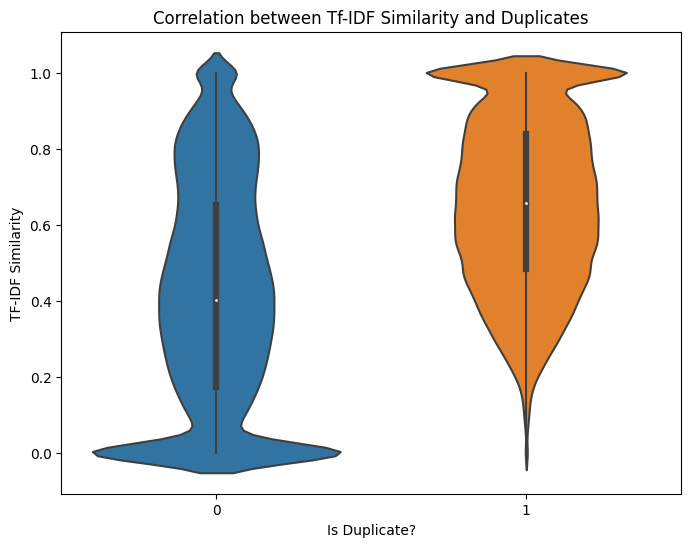

In [78]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='tfidf_similarity', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('TF-IDF Similarity')
plt.title('Correlation between Tf-IDF Similarity and Duplicates')
plt.show()

In [79]:
correlation_coefficient = X_train['tfidf_similarity'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.39442460586719913


### Difference in Question Character Count

In [50]:
X_train['char_count_diff'] = abs(X_train['question1'].str.len() - X_train['question2'].str.len())
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6,0.833333,colour water,colour water,1.000000,1.000000,4
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13,0.650000,would bedroom year 1980 look like would older ...,would older man bedroom look like year 1980,0.888889,0.910786,32
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5,0.285714,prosecco go,unopened champagne go bad,0.200000,0.123890,10
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13,0.333333,opt chemical engineering super interested chem...,study chemical engineering like good chemistry,0.333333,0.526283,2
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9,0.230769,eat eggs banana,dangerous eat bananas eggs together,0.333333,0.435171,18


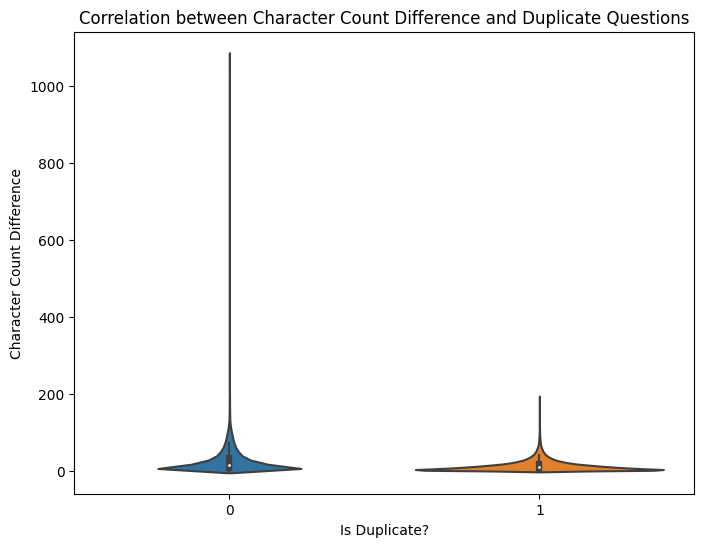

In [51]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='char_count_diff', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Character Count Difference')
plt.title('Correlation between Character Count Difference and Duplicate Questions')
plt.show()

In [52]:
correlation_coefficient = X_train['char_count_diff'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.20992580946119957


### Difference in Question Length

Check if there is a correlation between question having the same lengths and the question pair being a duplicate

There doesn't seem to be a correlation, so the `question_length_diff` feature may not be too useful.

In [53]:
X_train['question_length_diff'] = abs(X_train['question1_word_count'] - X_train['question2_word_count'])
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6,0.833333,colour water,colour water,1.000000,1.000000,4,1
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13,0.650000,would bedroom year 1980 look like would older ...,would older man bedroom look like year 1980,0.888889,0.910786,32,8
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5,0.285714,prosecco go,unopened champagne go bad,0.200000,0.123890,10,1
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13,0.333333,opt chemical engineering super interested chem...,study chemical engineering like good chemistry,0.333333,0.526283,2,0
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9,0.230769,eat eggs banana,dangerous eat bananas eggs together,0.333333,0.435171,18,2


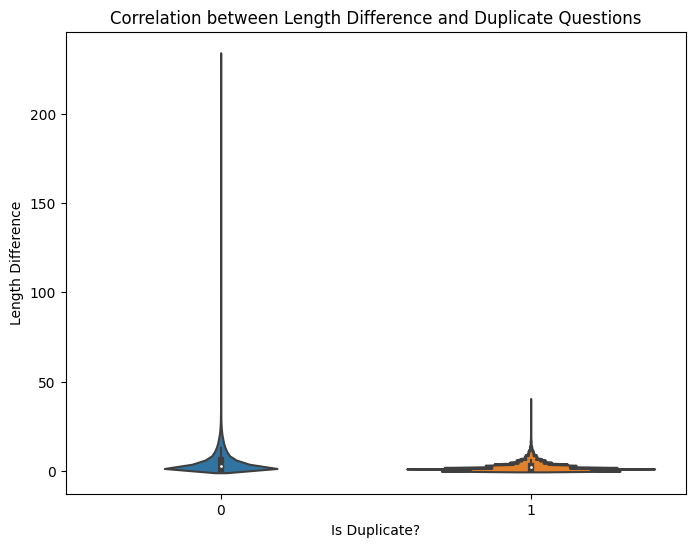

In [54]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='question_length_diff', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Length Difference')
plt.title('Correlation between Length Difference and Duplicate Questions')
plt.show()

There is not much correlation, this feature might not be too important.

In [55]:
correlation_coefficient = X_train['question_length_diff'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.20372193364065871


### Word Embeddings (`Word2Vec`)

In [56]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

questions = []

q1_concat_q2 = pd.concat([X_train['cleaned_question1'], X_train['cleaned_question2']])
q1_concat_q2.head()

107500                             what is colour of water 
300891    what would a bedroom in the year 1980 look lik...
292925                                does prosecco go off 
271797    should i opt for chemical engineering if i am ...
230516                      can i eat eggs and banana only 
dtype: object

In [58]:
for q in q1_concat_q2:
  words = word_tokenize(q)

  questions.append(words)

In [59]:
model = Word2Vec(questions, vector_size=10, window=3, min_count=1, sg=1)

In [60]:
model.save('/content/drive/MyDrive/ay2324 sem1/cs3244/project/word2_vec_simple_classifier.model')

In [61]:
def calculate_embeddings_similarity(df, model):
  similarities = []

  for _, row in df.iterrows():
    q1 = row['cleaned_question1']
    q2 = row['cleaned_question2']

    # Tokenize and preprocess the questions as needed
    words_1 = word_tokenize(q1)
    words_2 = word_tokenize(q2)

    # Filter out words that are not present in the Word2Vec model
    words_1 = [word for word in words_1 if word in model.wv]
    words_2 = [word for word in words_2 if word in model.wv]

    # Calculate the average Word2Vec embeddings for each question
    if words_1 and words_2:
      embedding_1 = np.mean([model.wv[word] for word in words_1], axis=0)
      embedding_2 = np.mean([model.wv[word] for word in words_2], axis=0)
      similarity = cosine_similarity([embedding_1], [embedding_2])[0][0]
    else:
      similarity = 0.0

    similarities.append(similarity)

  return pd.Series(similarities)

In [62]:
X_train['embeddings_similarity'] = calculate_embeddings_similarity(X_train, model)

In [63]:
X_train.head()

,id,qid1,qid2,question1,question2,cleaned_question1,cleaned_question2,question1_word_count,question2_word_count,common_word_proportion,no_stops_question1,no_stops_question2,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff,embeddings_similarity
107500,107500,176853,176854,What is colour of water?,What is the colour of water?,what is colour of water,what is the colour of water,5,6,0.833333,colour water,colour water,1.000000,1.000000,4,1,0.999637
300891,300891,111985,70822,What would a bedroom in the year 1980 look lik...,What would an older man's bedroom look like in...,what would a bedroom in the year 1980 look lik...,what would an older man s bedroom look like in...,21,13,0.650000,would bedroom year 1980 look like would older ...,would older man bedroom look like year 1980,0.888889,0.910786,32,8,NaN
292925,292925,414609,414610,Does prosecco go off?,Does unopened champagne go bad?,does prosecco go off,does unopened champagne go bad,4,5,0.285714,prosecco go,unopened champagne go bad,0.200000,0.123890,10,1,NaN
271797,271797,389950,196146,Should I opt for Chemical Engineering if I am ...,Should I study chemical engineering because I ...,should i opt for chemical engineering if i am ...,should i study chemical engineering because i ...,13,13,0.333333,opt chemical engineering super interested chem...,study chemical engineering like good chemistry,0.333333,0.526283,2,0,0.993423
230516,230516,260341,340072,Can I eat eggs and banana only?,Is it dangerous to eat bananas and eggs together?,can i eat eggs and banana only,is it dangerous to eat bananas and eggs together,7,9,0.230769,eat eggs banana,dangerous eat bananas eggs together,0.333333,0.435171,18,2,0.923169


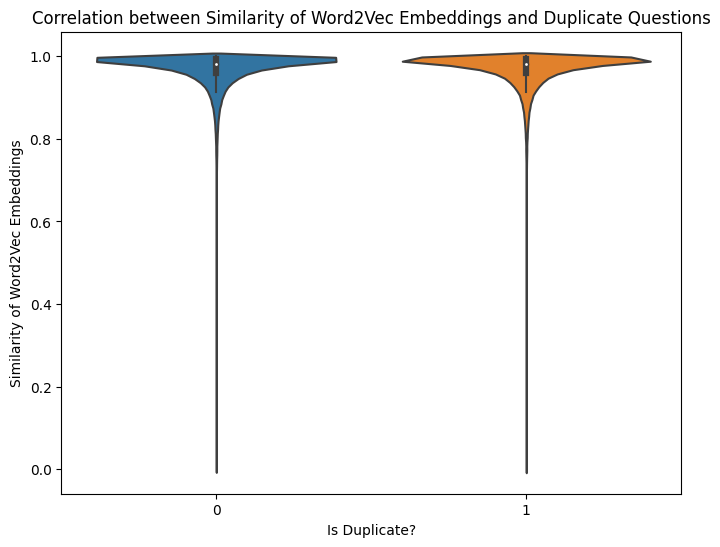

In [64]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=y_train, y='embeddings_similarity', data=X_train)
plt.xlabel('Is Duplicate?')
plt.ylabel('Similarity of Word2Vec Embeddings')
plt.title('Correlation between Similarity of Word2Vec Embeddings and Duplicate Questions')
plt.show()

In [65]:
correlation_coefficient = X_train['embeddings_similarity'].corr(y_train)
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.0005142747896340351


### Extracting Numerical Features

In [80]:
X_train_filtered = X_train[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_train_filtered.head()

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
107500,5,6,0.833333,1.000000,1.000000,4,1
300891,21,13,0.650000,0.888889,0.910786,32,8
292925,4,5,0.285714,0.200000,0.123890,10,1
271797,13,13,0.333333,0.333333,0.526283,2,0
230516,7,9,0.230769,0.333333,0.435171,18,2


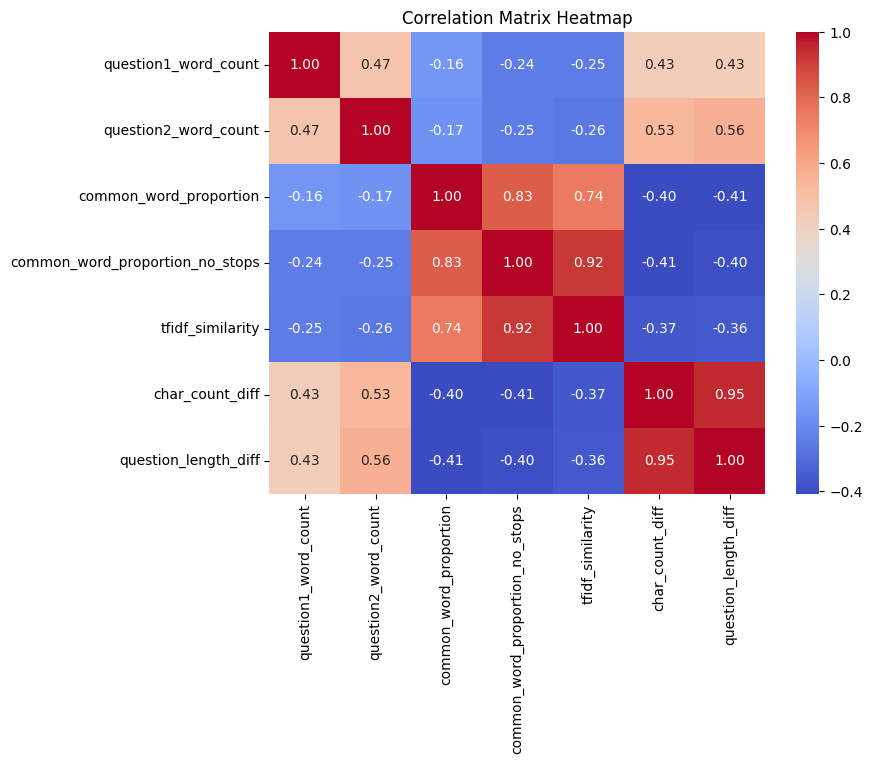

In [81]:
correlation_matrix = X_train_filtered.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# Training Simple Classifiers

In [82]:
from joblib import load
tfidf_vectorizer = load('/content/drive/MyDrive/ay2324 sem1/cs3244/project/tfidf_vectorizer.joblib')

def transform_question_pairs(val_test):
  df = val_test.copy()

  df['cleaned_question1'] = df['question1'].apply(clean_text)
  df['cleaned_question2'] = df['question2'].apply(clean_text)

  df['question1_word_count'] = df['cleaned_question1'].apply(lambda x: len(str(x).split()))
  df['question2_word_count'] = df['cleaned_question2'].apply(lambda x: len(str(x).split()))

  df['common_word_proportion'] = df.apply(lambda row: calculate_common_word_proportion(row['cleaned_question1'], row['cleaned_question2']), axis=1)

  df['no_stops_question1'] = df['question1'].apply(lambda x: clean_text(x, remove_stopwords=True))
  df['no_stops_question2'] = df['question2'].apply(lambda x: clean_text(x, remove_stopwords=True))

  df['common_word_proportion_no_stops'] = df.apply(lambda row: calculate_common_word_proportion(row['no_stops_question1'], row['no_stops_question2']), axis=1)

  q1 = df['no_stops_question1']
  q2 = df['no_stops_question2']
  q1_concat_q2 = pd.concat([q1, q2])

  tfidf_matrix_df = tfidf_vectorizer.transform(q1_concat_q2)

  df['tfidf_similarity'] = [tfidf_word_share(i, i + len(df), tfidf_matrix_df) for i in range(len(df))]

  df['char_count_diff'] = abs(df['question1'].str.len() - df['question2'].str.len())
  df['question_length_diff'] = abs(df['question1_word_count'] - df['question2_word_count'])

  return df

In [85]:
X_val = transform_question_pairs(X_val)
X_val_filtered = X_val[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_val_filtered.head()

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
238575,9,9,0.800000,0.600000,0.836703,4,0
55283,16,15,0.160000,0.142857,0.419086,25,1
168650,10,12,0.666667,0.600000,0.697218,7,2
375327,7,5,0.090909,0.200000,0.614716,14,2
180642,12,10,0.500000,0.500000,0.722743,11,2


In [86]:
X_test = transform_question_pairs(X_test)
X_test_filtered = X_test[['question1_word_count', 'question2_word_count', 'common_word_proportion', 'common_word_proportion_no_stops', 'tfidf_similarity', 'char_count_diff', 'question_length_diff']]
X_test_filtered.head()

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff
8067,9,9,0.800000,0.666667,0.787739,0,0
224279,7,11,0.133333,0.285714,0.439308,23,4
252452,7,22,0.076923,0.153846,0.504831,73,15
174039,10,21,0.000000,0.000000,0.000000,79,11
384863,7,11,0.384615,0.333333,0.597859,23,4


In [87]:
X_test_filtered[X_test_filtered.isnull().values.any(1)]

,question1_word_count,question2_word_count,common_word_proportion,common_word_proportion_no_stops,tfidf_similarity,char_count_diff,question_length_diff


#### SVM
Without CV

In [ ]:
from sklearn.svm import SVC

# initialize SVM model
svm_model = SVC(C=1.0, kernel='rbf', degree=3)

svm_model.fit(X_train_filtered, y_train)

# predict on validation set
svm_val_predictions = svm_model.predict(X_val_filtered)

# predict on test set
svm_test_predictions = svm_model.predict(X_test_filtered)

In [134]:
svm_train_predictions = svm_model.predict(X_train_filtered)
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)

print(f"SVM Train Accuracy: {svm_train_accuracy * 100:.2f}%")

SVM Train Accuracy: 68.11%


In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# evaluate metrics on validation set
svm_val_accuracy = accuracy_score(y_val, svm_val_predictions)
svm_val_precision = precision_score(y_val, svm_val_predictions)
svm_val_recall = recall_score(y_val, svm_val_predictions)
svm_val_f1 = f1_score(y_val, svm_val_predictions)
svm_val_auc_roc = roc_auc_score(y_val, svm_val_predictions)

print(f"SVM Validation Accuracy: {svm_val_accuracy * 100:.2f}%")
print(f"SVM Validation Precision: {svm_val_precision * 100:.2f}%")
print(f"SVM Validation Recall: {svm_val_recall * 100:.2f}%")
print(f"SVM Validation F1-Score: {svm_val_f1 * 100:.2f}%")
print(f"SVM Validation AUC-ROC: {svm_val_auc_roc * 100:.2f}%")

print()

# evaluate metrics on test set
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)
svm_test_precision = precision_score(y_test, svm_test_predictions)
svm_test_recall = recall_score(y_test, svm_test_predictions)
svm_test_f1 = f1_score(y_test, svm_test_predictions)
svm_test_auc_roc = roc_auc_score(y_test, svm_test_predictions)

print(f"SVM Test Accuracy: {svm_test_accuracy * 100:.2f}%")
print(f"SVM Test Precision: {svm_test_precision * 100:.2f}%")
print(f"SVM Test Recall: {svm_test_recall * 100:.2f}%")
print(f"SVM Test F1-Score: {svm_test_f1 * 100:.2f}%")
print(f"SVM Test AUC-ROC: {svm_test_auc_roc * 100:.2f}%")

SVM Validation Accuracy: 67.93%
SVM Validation Precision: 60.09%
SVM Validation Recall: 41.59%
SVM Validation F1-Score: 49.16%
SVM Validation AUC-ROC: 62.59%

SVM Test Accuracy: 68.11%
SVM Test Precision: 59.58%
SVM Test Recall: 42.14%
SVM Test F1-Score: 49.37%
SVM Test AUC-ROC: 62.71%


In [112]:
import joblib
from datetime import datetime

def save_model(model, model_type=None):
  today = datetime.now().strftime('%Y-%m-%d')
  model_filepath = f'/content/drive/MyDrive/ay2324 sem1/cs3244/project/{model_type}_{today}.pkl'
  joblib.dump(model, model_filepath)

def load_model(model_filepath):
  return joblib.load(model_filepath)

In [114]:
save_model(svm_model, model_type='svm')

In [ ]:
# load saved model
# loaded svm_model = joblib.load(svm_model_filepath)

#### Logistic Regression
Without CV

In [98]:
from sklearn.linear_model import LogisticRegression

# initialise Logistic Regression model
lr_model = LogisticRegression(penalty='l2', solver='sag', max_iter=1000)

# train Logistic Regression model
lr_model.fit(X_train_filtered, y_train)

# Predict on the validation set
lr_val_predictions = lr_model.predict(X_val_filtered)

# Predict on the test set
lr_test_predictions = lr_model.predict(X_test_filtered)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [104]:
# evalute metrics on validation set
lr_val_accuracy = accuracy_score(y_val, lr_val_predictions)
lr_val_precision = precision_score(y_val, lr_val_predictions)
lr_val_recall = recall_score(y_val, lr_val_predictions)
lr_val_f1 = f1_score(y_val, lr_val_predictions)
lr_val_auc_roc = roc_auc_score(y_val, lr_val_predictions)

print(f"Logistic Regression Validation Accuracy: {lr_val_accuracy * 100:.2f}%")
print(f"Logistic Regression Validation Precision: {lr_val_precision * 100:.2f}%")
print(f"Logistic Regression Validation Recall: {lr_val_recall * 100:.2f}%")
print(f"Logistic Regression Validation F1-Score: {lr_val_f1 * 100:.2f}%")
print(f"Logistic Regression Validation AUC-ROC: {lr_val_auc_roc * 100:.2f}%")

print()

# evaluate metrics on test set
lr_test_accuracy = accuracy_score(y_test, lr_test_predictions)
lr_test_precision = precision_score(y_test, lr_test_predictions)
lr_test_recall = recall_score(y_test, lr_test_predictions)
lr_test_f1 = f1_score(y_test, lr_test_predictions)
lr_test_auc_roc = roc_auc_score(y_test, lr_test_predictions)

print(f"Logistic Regression Test Accuracy: {lr_test_accuracy * 100:.2f}%")
print(f"Logistic Regression Test Precision: {lr_test_precision * 100:.2f}%")
print(f"Logistic Regression Test Recall: {lr_test_recall * 100:.2f}%")
print(f"Logistic Regression Test F1-Score: {lr_test_f1 * 100:.2f}%")
print(f"Logistic Regression Test AUC-ROC: {lr_test_auc_roc * 100:.2f}%")

Logistic Regression Validation Accuracy: 65.13%
Logistic Regression Validation Precision: 54.11%
Logistic Regression Validation Recall: 42.50%
Logistic Regression Validation F1-Score: 47.60%
Logistic Regression Validation AUC-ROC: 60.54%

Logistic Regression Test Accuracy: 65.49%
Logistic Regression Test Precision: 54.05%
Logistic Regression Test Recall: 43.13%
Logistic Regression Test F1-Score: 47.97%
Logistic Regression Test AUC-ROC: 60.84%


In [108]:
save_model(lr_model, model_type='lr')

With CV

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 0.5, 1, 10],
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg'],
    'max_iter': [500, 1000, 5000, 10000]
}

lr_grid_search = GridSearchCV(lr_model, param_grid, scoring='accuracy')

lr_grid_search.fit(X_train_filtered, y_train)

best_lr_model = lr_grid_search.best_estimator_

lr_cv_val_predictions = best_lr_model.predict(X_val_filtered)

lr_cv_test_predictions = best_lr_model.predict(X_test_filtered)

In [109]:
save_model(best_lr_model, model_type='lr_cv')

In [135]:
lr_train_predictions = best_lr_model.predict(X_train_filtered)
lr_train_accuracy = accuracy_score(y_train, lr_train_predictions)

print(f"Logistic Regression Train Accuracy: {lr_train_accuracy * 100:.2f}%")

Logistic Regression Train Accuracy: 65.63%


In [110]:
# evalute metrics on validation set
lr_cv_val_accuracy = accuracy_score(y_val, lr_cv_val_predictions)
lr_cv_val_precision = precision_score(y_val, lr_cv_val_predictions)
lr_cv_val_recall = recall_score(y_val, lr_cv_val_predictions)
lr_cv_val_f1 = f1_score(y_val, lr_cv_val_predictions)
lr_cv_val_auc_roc = roc_auc_score(y_val, lr_cv_val_predictions)

print(f"Logistic Regression Validation Accuracy: {lr_cv_val_accuracy * 100:.2f}%")
print(f"Logistic Regression Validation Precision: {lr_cv_val_precision * 100:.2f}%")
print(f"Logistic Regression Validation Recall: {lr_cv_val_recall * 100:.2f}%")
print(f"Logistic Regression Validation F1-Score: {lr_cv_val_f1 * 100:.2f}%")
print(f"Logistic Regression Validation AUC-ROC: {lr_cv_val_auc_roc * 100:.2f}%")

print()

# evaluate metrics on test set
lr_cv_test_accuracy = accuracy_score(y_test, lr_cv_test_predictions)
lr_cv_test_precision = precision_score(y_test, lr_cv_test_predictions)
lr_cv_test_recall = recall_score(y_test, lr_cv_test_predictions)
lr_cv_test_f1 = f1_score(y_test, lr_cv_test_predictions)
lr_cv_test_auc_roc = roc_auc_score(y_test, lr_cv_test_predictions)

print(f"Logistic Regression Test Accuracy: {lr_cv_test_accuracy * 100:.2f}%")
print(f"Logistic Regression Test Precision: {lr_cv_test_precision * 100:.2f}%")
print(f"Logistic Regression Test Recall: {lr_cv_test_recall * 100:.2f}%")
print(f"Logistic Regression Test F1-Score: {lr_cv_test_f1 * 100:.2f}%")
print(f"Logistic Regression Test AUC-ROC: {lr_cv_test_auc_roc * 100:.2f}%")

Logistic Regression Validation Accuracy: 65.19%
Logistic Regression Validation Precision: 54.16%
Logistic Regression Validation Recall: 43.02%
Logistic Regression Validation F1-Score: 47.95%
Logistic Regression Validation AUC-ROC: 60.69%

Logistic Regression Test Accuracy: 65.50%
Logistic Regression Test Precision: 54.03%
Logistic Regression Test Recall: 43.57%
Logistic Regression Test F1-Score: 48.24%
Logistic Regression Test AUC-ROC: 60.95%


#### $k$-NN

Without CV

In [148]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=20)

knn_model.fit(X_train_filtered, y_train)

knn_val_predictions = knn_model.predict(X_val_filtered)

knn_test_predictions = knn_model.predict(X_test_filtered)

In [149]:
save_model(knn_model, model_type='knn')

In [150]:
knn_train_predictions = knn_model.predict(X_train_filtered)
knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)

print(f"kNN Train Accuracy: {knn_train_accuracy * 100:.2f}%")

kNN Train Accuracy: 72.75%


In [151]:
# evaluate validation Metrics
knn_val_accuracy = accuracy_score(y_val, knn_val_predictions)
knn_val_precision = precision_score(y_val, knn_val_predictions)
knn_val_recall = recall_score(y_val, knn_val_predictions)
knn_val_f1 = f1_score(y_val, knn_val_predictions)
knn_val_auc_roc = roc_auc_score(y_val, knn_val_predictions)


print(f"kNN Validation Accuracy: {knn_val_accuracy * 100:.2f}%")
print(f"kNN Validation Precision: {knn_val_precision * 100:.2f}%")
print(f"kNN Validation Recall: {knn_val_recall * 100:.2f}%")
print(f"kNN Validation F1-Score: {knn_val_f1 * 100:.2f}%")
print(f"kNN Validation AUC-ROC: {knn_val_auc_roc * 100:.2f}%")

print()

# valuate test metrics
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)
knn_test_precision = precision_score(y_test, knn_test_predictions)
knn_test_recall = recall_score(y_test, knn_test_predictions)
knn_test_f1 = f1_score(y_test, knn_test_predictions)
knn_test_auc_roc = roc_auc_score(y_test, knn_test_predictions)

print(f"kNN Test Accuracy: {knn_test_accuracy * 100:.2f}%")
print(f"kNN Test Precision: {knn_test_precision * 100:.2f}%")
print(f"kNN Test Recall: {knn_test_recall * 100:.2f}%")
print(f"kNN Test F1-Score: {knn_test_f1 * 100:.2f}%")
print(f"kNN Test AUC-ROC: {knn_test_auc_roc * 100:.2f}%")

kNN Validation Accuracy: 68.60%
kNN Validation Precision: 60.47%
kNN Validation Recall: 45.52%
kNN Validation F1-Score: 51.94%
kNN Validation AUC-ROC: 63.92%

kNN Test Accuracy: 69.08%
kNN Test Precision: 60.74%
kNN Test Recall: 45.82%
kNN Test F1-Score: 52.23%
kNN Test AUC-ROC: 64.25%


With CV

In [152]:
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [5, 7, 9, 12, 15, 20, 30, 50, 75]
}

knn_grid_search = GridSearchCV(knn_model, param_grid, scoring='accuracy')

knn_grid_search.fit(X_train_filtered, y_train)

best_knn_model = knn_grid_search.best_estimator_

knn_cv_val_predictions = best_knn_model.predict(X_val_filtered)

knn_cv_test_predictions = best_knn_model.predict(X_test_filtered)

In [153]:
knn_grid_search.best_params_

{'n_neighbors': 15}

In [154]:
save_model(best_knn_model, model_type='knn_cv')

In [155]:
knn_cv_train_predictions = best_knn_model.predict(X_train_filtered)

knn_cv_train_accuracy = accuracy_score(y_train, knn_cv_train_predictions)

print(f"kNN Train Accuracy: {knn_cv_train_accuracy * 100:.2f}%")

kNN Train Accuracy: 73.89%


In [156]:
# evaluate validation Metrics
knn_cv_val_accuracy = accuracy_score(y_val, knn_cv_val_predictions)
knn_cv_val_precision = precision_score(y_val, knn_cv_val_predictions)
knn_cv_val_recall = recall_score(y_val, knn_cv_val_predictions)
knn_cv_val_f1 = f1_score(y_val, knn_cv_val_predictions)
knn_cv_val_auc_roc = roc_auc_score(y_val, knn_cv_val_predictions)


print(f"kNN Validation Accuracy: {knn_cv_val_accuracy * 100:.2f}%")
print(f"kNN Validation Precision: {knn_cv_val_precision * 100:.2f}%")
print(f"kNN Validation Recall: {knn_cv_val_recall * 100:.2f}%")
print(f"kNN Validation F1-Score: {knn_cv_val_f1 * 100:.2f}%")
print(f"kNN Validation AUC-ROC: {knn_cv_val_auc_roc * 100:.2f}%")

print()

# valuate test metrics
knn_cv_test_accuracy = accuracy_score(y_test, knn_cv_test_predictions)
knn_cv_test_precision = precision_score(y_test, knn_cv_test_predictions)
knn_cv_test_recall = recall_score(y_test, knn_cv_test_predictions)
knn_cv_test_f1 = f1_score(y_test, knn_cv_test_predictions)
knn_cv_test_auc_roc = roc_auc_score(y_test, knn_cv_test_predictions)

print(f"kNN Test Accuracy: {knn_cv_test_accuracy * 100:.2f}%")
print(f"kNN Test Precision: {knn_cv_test_precision * 100:.2f}%")
print(f"kNN Test Recall: {knn_cv_test_recall * 100:.2f}%")
print(f"kNN Test F1-Score: {knn_cv_test_f1 * 100:.2f}%")
print(f"kNN Test AUC-ROC: {knn_cv_test_auc_roc * 100:.2f}%")

kNN Validation Accuracy: 68.78%
kNN Validation Precision: 59.27%
kNN Validation Recall: 51.90%
kNN Validation F1-Score: 55.34%
kNN Validation AUC-ROC: 65.35%

kNN Test Accuracy: 69.24%
kNN Test Precision: 59.41%
kNN Test Recall: 52.50%
kNN Test F1-Score: 55.75%
kNN Test AUC-ROC: 65.77%
